In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, pairwise_distances
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('genes.csv')

#1. Preprocesamiento y división de los datos para la implementación del algoritmo k-nearest-neighbours

# Dividir los datos en características (X) y etiquetas (y)
X = data.drop('CancerPresent', axis=1)
y = data['CancerPresent']

# Dividir los datos en conjunto de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# 2. Definir las configuraciones de los hiperparámetros
## ¿Que decisiones has tomado? ¿Por que?
## La primera optar por ks proximas a la óptima, y ver cual es la que clasifica mejor, como se ve a continuación en el  código.
## La segunda, utilizar unicamente las medidas de valores continuos, ya que son los que presenta nuestra base de datos, y ver cual de las dos es la que clasifica mejor.


In [25]:
# Calcular la matriz de distancias entre todas las observaciones en X_test_ps
distances_matrix = pairwise_distances(X_test)

# Encontrar la k más óptima
max_distance = distances_matrix.max()
k = 2/max_distance
print(k)


0.38158866395832536


# Vemos que teoricamente la k más óptima debería ser algo aproximado a 3.8
# El primer parámetro 'k_values', son el número de individuos que vamos a usar para clasificar una nueva instancia

In [26]:

k_values = [3, 4, 5]

# El segundo,  es la distancia de esa nueva instancia con el resto, para ello probaremos 2 medidas distintas, unicamente las de valores continuos 
metrics = ['euclidean', 'manhattan']

best_accuracy = 0
best_config = None
results = []

# Iterar sobre las configuraciones de los hiperparámetros
for k in k_values:
    for metric in metrics:
        # Entrenar el modelo
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train, y_train)
        
        # Predecir en el conjunto de validación
        y_pred = knn.predict(X_val)
        
        # Calcular la precisión
        accuracy = accuracy_score(y_val, y_pred)
        
        # Guardar los resultados
        results.append([k, metric, accuracy])
        
        # Actualizar la mejor configuración
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_config = (k, metric)


In [27]:
# 3. Tabla y resultados
# Mostramos los resultados en una tabla para el conjunto de validacion
print("Resultados:")
print(pd.DataFrame(results, columns=['k', 'metric', 'accuracy']))

# Entrenar el modelo con la mejor configuración (K = 3, distancia euclidea)
best_k, best_metric = best_config
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
best_knn.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_test_pred = best_knn.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)

conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\nMejor configuración:")
print("k =", best_k)
print("Métrica =", best_metric)
print("Precisión en el conjunto de prueba:", test_accuracy)
print("Matriz de confusión:")
print(conf_matrix)


Resultados:
   k     metric  accuracy
0  3  euclidean  0.944444
1  3  manhattan  0.944444
2  4  euclidean  0.942222
3  4  manhattan  0.937778
4  5  euclidean  0.937778
5  5  manhattan  0.937778

Mejor configuración:
k = 3
Métrica = euclidean
Precisión en el conjunto de prueba: 0.9088888888888889
Matriz de confusión:
[[210  18]
 [ 23 199]]


# Obtenemos una precisión del 91%, para las métricas espicificadas, con 18 FP y 23 FN.
# Graficamos la matriz de confusión unicamente de la mejor configuracion, ya que la diferencia respecto de las demas es muy pequeña y no se aprecia al representarlas.

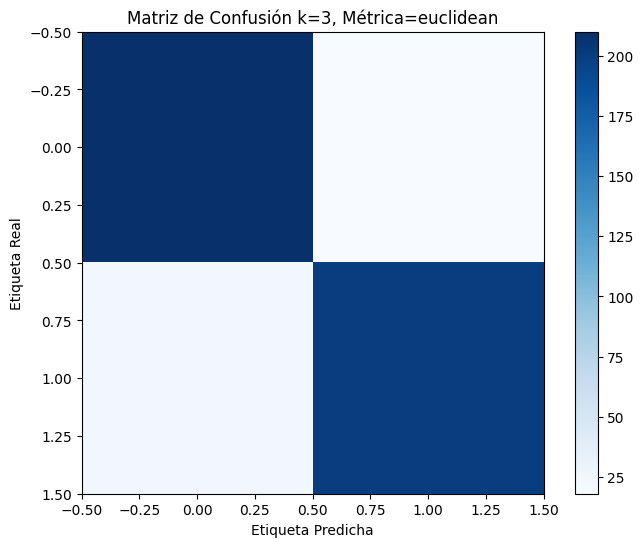

In [28]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Matriz de Confusión k={best_k}, Métrica={best_metric}')
plt.colorbar()
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

# 4. Creo un nuevo set de datos llamado pacientes_test

In [29]:
# Seleccionar 25 índices aleatorios del conjunto de prueba

test_indices = X_test.shape[0]
np.random.seed(42)
test_indices_selected = range(10)
pacientes_test = data.iloc[test_indices_selected]

# Guardar las observaciones seleccionadas en un nuevo archivo CSV
pd.DataFrame(pacientes_test, columns=X.columns).to_csv('pacientes_test.csv', index=False)

# Cargar el conjunto de datos de prueba
pacientes_test = pd.read_csv('pacientes_test.csv')
 
# Escalar las características 
X_test_ps = scaler.transform(pacientes_test)

y_test_pred_p = best_knn.predict(X_test_ps)

# Imprimir las predicciones y los valores reales
print("\nPredicciones de cáncer para los pacientes de prueba:")
for i, prediction in enumerate(y_test_pred_p):
    print(f"Paciente {i+1}: Cáncer presente" if prediction == 1 else f"Paciente {i+1}: No hay cáncer")



Predicciones de cáncer para los pacientes de prueba:
Paciente 1: Cáncer presente
Paciente 2: No hay cáncer
Paciente 3: Cáncer presente
Paciente 4: No hay cáncer
Paciente 5: Cáncer presente
Paciente 6: No hay cáncer
Paciente 7: No hay cáncer
Paciente 8: No hay cáncer
Paciente 9: No hay cáncer
Paciente 10: Cáncer presente



# Lo que hemos hecho es coger los primeros 10 valores de nuestro set de datos, y con ellos creamos un nuevo archivo csv llamado pacientes_test, posteriormente hemos aplicado nuestro modelo entrenado a este conjunto para ver como responde ante 'nuevos datos', lo que obtenemos es que acierta 9/10, lo que tiene sentido ya que en el conjunto de prueba obtenemos una precisión del 91%.